In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

In [22]:
def plot_series(time,series,start = 0,end = None,format = "-",label =None):
    plt.plot(time[start:end],series[start:end],format,label = label)
    plt.xlabel("Time")
    plt.ylabel("Values")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)
    
def trend(time,slope = 0):
    return time * slope

def season_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(2*season_time*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude = 1,phase = 0):
    season_time = ((time + phase)%period)/period
    return amplitude * season_pattern(season_time)

def white_noise(time,noise_level,seed = 0):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

def seq2seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer = 1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift = 1,drop_remainder = True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w:(w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift =1,drop_remainder = True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

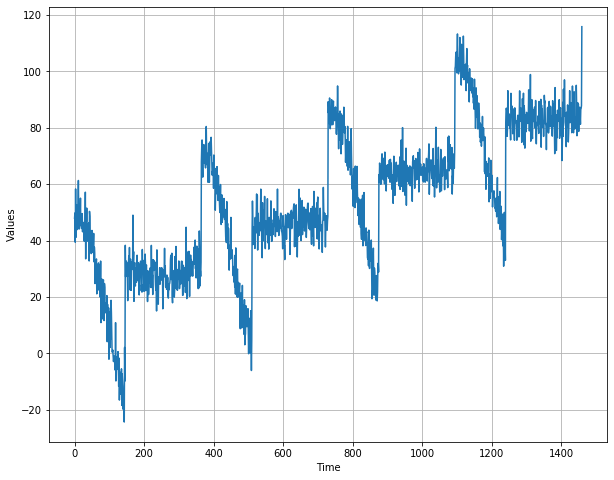

In [3]:
time = np.arange(4*365+1)

slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time,slope) + seasonality(time,period = 365,amplitude = amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed = 2)

series += noise

plt.figure(figsize=(10,8))
plot_series(time,series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing with 1-D convolutional Layer

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size = 128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32,kernel_size =5,activation="relu",
                       strides = 1,padding='causal',input_shape = [None,1]),
    keras.layers.LSTM(32,return_sequences = True),
    keras.layers.LSTM(32,return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10**(epoch/20)
)

optimizer = keras.optimizers.SGD(lr = 1e-8 ,momentum = 0.9)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set,epochs = 100,
                   callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 428ms/step - loss: 87.3120 - mae: 88.1151
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 87.0784 - mae: 87.3935
Epoch 3/100
8/8 [==============================] - 1s 66ms/step - loss: 85.6263 - mae: 86.2185
Epoch 4/100
8/8 [==============================] - 1s 67ms/step - loss: 84.1171 - mae: 84.6626
Epoch 5/100
8/8 [==============================] - 1s 66ms/step - loss: 82.2904 - mae: 82.7776
Epoch 6/100
8/8 [==============================] - 1s 69ms/step - loss: 79.8776 - mae: 80.5575
Epoch 7/100
8/8 [==============================] - 1s 69ms/step - loss: 77.5376 - mae: 78.0743
Epoch 8/100
8/8 [==============================] - 1s 67ms/step - loss: 74.8664 - mae: 75.4392
Epoch 9/100
8/8 [==============================] - 1s 68ms/step - loss: 72.3769 - mae: 72.7970
Epoch 10/100
8/8 [==============================] - 1s 66ms/step - loss: 69.7223 - mae: 70.2557
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 64ms/step - loss: 17.1356 - mae: 17.5040
Epoch 88/100
8/8 [==============================] - 0s 62ms/step - loss: 16.6516 - mae: 17.3380
Epoch 89/100
8/8 [==============================] - 1s 64ms/step - loss: 11.0459 - mae: 11.7090
Epoch 90/100
8/8 [==============================] - 1s 64ms/step - loss: 13.6966 - mae: 14.3457
Epoch 91/100
8/8 [==============================] - 1s 64ms/step - loss: 17.1760 - mae: 18.0245
Epoch 92/100
8/8 [==============================] - 1s 63ms/step - loss: 13.6404 - mae: 13.9846
Epoch 93/100
8/8 [==============================] - 1s 73ms/step - loss: 13.6778 - mae: 14.3157
Epoch 94/100
8/8 [==============================] - 1s 71ms/step - loss: 14.3309 - mae: 14.9703
Epoch 95/100
8/8 [==============================] - 1s 64ms/step - loss: 14.1817 - mae: 14.4045
Epoch 96/100
8/8 [==============================] - 1s 67ms/step - loss: 22.5609 - mae: 23.3041
Epoch 97/100
8/8 [==============================] - 1

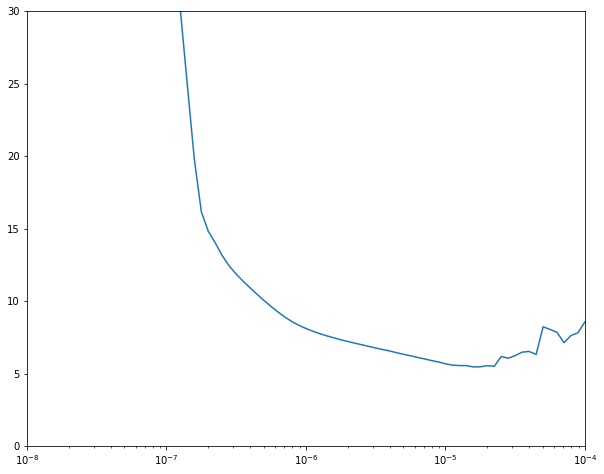

In [11]:
plt.figure(figsize=(10,8))
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8 ,1e-4 ,0 ,30])
plt.show()

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid,window_size,batch_size =128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 32,kernel_size = 5,activation = "relu",
                       strides = 1,padding = "causal",
                       input_shape = [None,1]),
    keras.layers.LSTM(32,return_sequences = True),
    keras.layers.LSTM(32,return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "CNN1D_checkpoint.h5",save_best_only = True)

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

optimizer = keras.optimizers.SGD(lr = 1e-5,momentum = 0.9)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

model.fit(train_set,epochs = 500,
         validation_data = valid_set,
         callbacks = [model_checkpoint,early_stopping])

Epoch 1/500
8/8 [==============================] - 5s 576ms/step - loss: 57.5024 - mae: 58.5300 - val_loss: 25.4260 - val_mae: 25.8423
Epoch 2/500
8/8 [==============================] - 1s 84ms/step - loss: 23.9468 - mae: 24.6642 - val_loss: 36.2992 - val_mae: 37.3911
Epoch 3/500
8/8 [==============================] - 1s 105ms/step - loss: 16.6935 - mae: 17.2866 - val_loss: 37.5368 - val_mae: 37.7214
Epoch 4/500
8/8 [==============================] - 1s 106ms/step - loss: 13.8626 - mae: 14.4266 - val_loss: 22.8086 - val_mae: 23.5690
Epoch 5/500
8/8 [==============================] - 1s 96ms/step - loss: 10.8135 - mae: 11.3667 - val_loss: 19.9135 - val_mae: 20.4873
Epoch 6/500
8/8 [==============================] - 1s 101ms/step - loss: 9.0238 - mae: 9.5656 - val_loss: 17.3113 - val_mae: 17.8956
Epoch 7/500
8/8 [==============================] - 1s 117ms/step - loss: 7.9854 - mae: 8.4649 - val_loss: 15.9746 - val_mae: 16.5874
Epoch 8/500
8/8 [==============================] - 1s 105ms/s

8/8 [==============================] - 1s 118ms/step - loss: 4.6598 - mae: 5.1296 - val_loss: 6.2960 - val_mae: 6.7282
Epoch 64/500
8/8 [==============================] - 1s 95ms/step - loss: 4.6966 - mae: 5.1595 - val_loss: 5.8359 - val_mae: 6.3452
Epoch 65/500
8/8 [==============================] - 1s 97ms/step - loss: 4.6660 - mae: 5.1537 - val_loss: 7.3622 - val_mae: 7.8717
Epoch 66/500
8/8 [==============================] - 1s 97ms/step - loss: 4.7090 - mae: 5.1867 - val_loss: 5.9317 - val_mae: 6.5004
Epoch 67/500
8/8 [==============================] - 1s 103ms/step - loss: 4.6619 - mae: 5.1386 - val_loss: 6.1780 - val_mae: 6.6724
Epoch 68/500
8/8 [==============================] - 1s 91ms/step - loss: 4.6511 - mae: 5.1279 - val_loss: 7.0869 - val_mae: 7.5846
Epoch 69/500
8/8 [==============================] - 1s 97ms/step - loss: 4.6234 - mae: 5.1042 - val_loss: 5.9408 - val_mae: 6.4319
Epoch 70/500
8/8 [==============================] - 1s 94ms/step - loss: 4.6021 - mae: 5.0841 

8/8 [==============================] - 1s 81ms/step - loss: 4.4925 - mae: 4.9638 - val_loss: 6.5674 - val_mae: 7.0184
Epoch 126/500
8/8 [==============================] - 1s 83ms/step - loss: 4.4783 - mae: 4.9571 - val_loss: 5.3564 - val_mae: 5.8806
Epoch 127/500
8/8 [==============================] - 1s 79ms/step - loss: 4.4197 - mae: 4.9055 - val_loss: 6.2790 - val_mae: 6.7299
Epoch 128/500
8/8 [==============================] - 1s 78ms/step - loss: 4.4534 - mae: 4.9333 - val_loss: 5.4627 - val_mae: 5.9518
Epoch 129/500
8/8 [==============================] - 1s 77ms/step - loss: 4.4490 - mae: 4.9222 - val_loss: 5.3725 - val_mae: 5.8937
Epoch 130/500
8/8 [==============================] - 1s 78ms/step - loss: 4.4045 - mae: 4.8875 - val_loss: 5.3776 - val_mae: 5.8522
Epoch 131/500
8/8 [==============================] - 1s 94ms/step - loss: 4.4248 - mae: 4.9057 - val_loss: 5.6194 - val_mae: 6.1292
Epoch 132/500
8/8 [==============================] - 1s 88ms/step - loss: 4.4902 - mae: 4.

8/8 [==============================] - 1s 80ms/step - loss: 4.3714 - mae: 4.8352 - val_loss: 5.5780 - val_mae: 6.0790
Epoch 188/500
8/8 [==============================] - 1s 81ms/step - loss: 4.3397 - mae: 4.8141 - val_loss: 5.1936 - val_mae: 5.6830
Epoch 189/500
8/8 [==============================] - 1s 79ms/step - loss: 4.3635 - mae: 4.8434 - val_loss: 5.4231 - val_mae: 5.8960
Epoch 190/500
8/8 [==============================] - 1s 78ms/step - loss: 4.3268 - mae: 4.8042 - val_loss: 5.4322 - val_mae: 5.9092
Epoch 191/500
8/8 [==============================] - 1s 80ms/step - loss: 4.3300 - mae: 4.8029 - val_loss: 5.3862 - val_mae: 5.8304
Epoch 192/500
8/8 [==============================] - 1s 81ms/step - loss: 4.3450 - mae: 4.8193 - val_loss: 5.8759 - val_mae: 6.3879
Epoch 193/500
8/8 [==============================] - 1s 80ms/step - loss: 4.3392 - mae: 4.8158 - val_loss: 5.2135 - val_mae: 5.6788
Epoch 194/500
8/8 [==============================] - 1s 91ms/step - loss: 4.3223 - mae: 4.

8/8 [==============================] - 1s 82ms/step - loss: 4.3055 - mae: 4.7889 - val_loss: 5.2301 - val_mae: 5.7169
Epoch 250/500
8/8 [==============================] - 1s 83ms/step - loss: 4.3279 - mae: 4.7951 - val_loss: 5.2095 - val_mae: 5.6971
Epoch 251/500
8/8 [==============================] - 1s 100ms/step - loss: 4.3193 - mae: 4.7882 - val_loss: 4.8521 - val_mae: 5.4195
Epoch 252/500
8/8 [==============================] - 1s 88ms/step - loss: 4.3196 - mae: 4.7902 - val_loss: 5.3640 - val_mae: 5.8733
Epoch 253/500
8/8 [==============================] - 1s 93ms/step - loss: 4.2967 - mae: 4.7795 - val_loss: 4.9645 - val_mae: 5.4222
Epoch 254/500
8/8 [==============================] - 1s 88ms/step - loss: 4.2881 - mae: 4.7637 - val_loss: 5.5567 - val_mae: 6.1092
Epoch 255/500
8/8 [==============================] - 1s 82ms/step - loss: 4.3397 - mae: 4.8163 - val_loss: 4.9581 - val_mae: 5.4292
Epoch 256/500
8/8 [==============================] - 1s 86ms/step - loss: 4.3723 - mae: 4

In [19]:
model = keras.models.load_model("CNN1D_checkpoint.h5")

In [23]:
rnn_forecast = model_forecast(model,series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

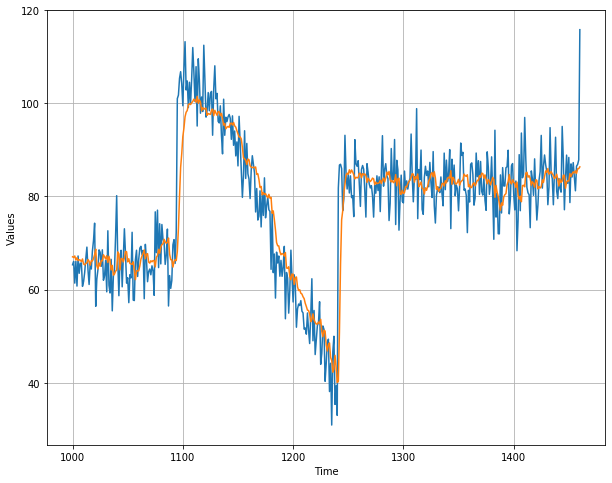

In [24]:
plt.figure(figsize=(10,8))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)
plt.show()

In [27]:
keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

4.8147745

## Full Convolutional Forecasting

In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = seq2seq_window_dataset(x_train,window_size,batch_size = 128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            strides = 1,
                            dilation_rate = dilation_rate,
                            padding = "causal",
                            activation = "relu")
        )
model.add(keras.layers.Conv1D(filters = 1,kernel_size = 1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-4 * 10**(epoch/30)
)

optimizer = keras.optimizers.Adam(lr = 1e-4)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set,epochs = 100,
                   callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 218ms/step - loss: 42.2939 - mae: 43.0363
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - loss: 42.3650 - mae: 42.6886
Epoch 3/100
8/8 [==============================] - 0s 45ms/step - loss: 41.8086 - mae: 42.3871
Epoch 4/100
8/8 [==============================] - 0s 45ms/step - loss: 41.5465 - mae: 42.1079
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 41.3332 - mae: 41.8177
Epoch 6/100
8/8 [==============================] - 0s 46ms/step - loss: 40.8610 - mae: 41.4480
Epoch 7/100
8/8 [==============================] - 0s 46ms/step - loss: 40.4315 - mae: 40.9212
Epoch 8/100
8/8 [==============================] - 0s 45ms/step - loss: 39.5702 - mae: 40.1137
Epoch 9/100
8/8 [==============================] - 0s 45ms/step - loss: 38.4233 - mae: 38.8244
Epoch 10/100
8/8 [==============================] - 0s 45ms/step - loss: 36.1565 - mae: 36.7187
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 56ms/step - loss: 7.8637 - mae: 8.4873
Epoch 88/100
8/8 [==============================] - 0s 48ms/step - loss: 5.2960 - mae: 5.7309
Epoch 89/100
8/8 [==============================] - 0s 49ms/step - loss: 9.2838 - mae: 9.9873
Epoch 90/100
8/8 [==============================] - 0s 43ms/step - loss: 9.5765 - mae: 10.1698
Epoch 91/100
8/8 [==============================] - 0s 60ms/step - loss: 9.8547 - mae: 10.3689
Epoch 92/100
8/8 [==============================] - 0s 55ms/step - loss: 8.2775 - mae: 8.8561
Epoch 93/100
8/8 [==============================] - 0s 45ms/step - loss: 10.7894 - mae: 11.3883
Epoch 94/100
8/8 [==============================] - 0s 55ms/step - loss: 10.1104 - mae: 10.2681
Epoch 95/100
8/8 [==============================] - 0s 56ms/step - loss: 9.3749 - mae: 10.0505
Epoch 96/100
8/8 [==============================] - 0s 56ms/step - loss: 9.9679 - mae: 10.2539
Epoch 97/100
8/8 [==============================] - 0s 52ms/step 

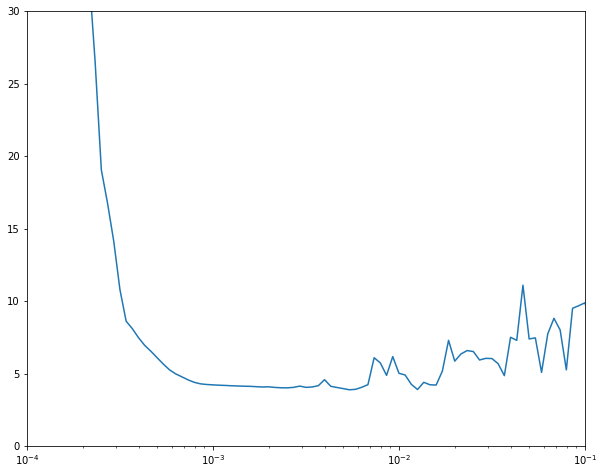

In [31]:
plt.figure(figsize=(10,8))
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4 , 1e-1,0,30])
plt.show()

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size)
valid_size = seq2seq_window_dataset(x_valid,window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            strides = 1,
                            activation = "relu",
                            dilation_rate = dilation_rate,
                            padding = "causal"
                           )
    )
model.add(keras.layers.Conv1D(filters =1,kernel_size = 1))

optimizer = keras.optimizers.Adam(lr = 3e-4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "CNN_full_checkpoint.h5",save_best_only = True)

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

model.fit(train_set,epochs = 500,
         validation_data = valid_set,
         callbacks = [model_checkpoint,early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 73ms/step - loss: 39.6003 - mae: 40.2427 - val_loss: 66.6585 - val_mae: 67.0419
Epoch 2/500
31/31 [==============================] - 1s 22ms/step - loss: 25.9078 - mae: 26.5259 - val_loss: 26.8331 - val_mae: 27.4253
Epoch 3/500
31/31 [==============================] - 1s 23ms/step - loss: 12.6073 - mae: 13.1703 - val_loss: 13.9620 - val_mae: 14.3990
Epoch 4/500
31/31 [==============================] - 1s 23ms/step - loss: 8.0027 - mae: 8.5122 - val_loss: 9.4880 - val_mae: 10.0241
Epoch 5/500
31/31 [==============================] - 1s 29ms/step - loss: 6.2250 - mae: 6.7236 - val_loss: 6.7240 - val_mae: 7.2124
Epoch 6/500
31/31 [==============================] - 1s 25ms/step - loss: 5.3231 - mae: 5.8144 - val_loss: 5.6985 - val_mae: 6.2024
Epoch 7/500
31/31 [==============================] - 1s 22ms/step - loss: 4.9689 - mae: 5.4443 - val_loss: 5.0603 - val_mae: 5.5430
Epoch 8/500
31/31 [==============================] - 1s 21ms/st

31/31 [==============================] - 1s 19ms/step - loss: 3.7678 - mae: 4.2324 - val_loss: 4.3065 - val_mae: 4.7578
Epoch 63/500
31/31 [==============================] - 1s 18ms/step - loss: 3.7259 - mae: 4.1867 - val_loss: 4.2058 - val_mae: 4.6949
Epoch 64/500
31/31 [==============================] - 1s 18ms/step - loss: 3.7144 - mae: 4.1870 - val_loss: 4.2096 - val_mae: 4.7034
Epoch 65/500
31/31 [==============================] - 1s 18ms/step - loss: 3.7096 - mae: 4.1823 - val_loss: 4.2653 - val_mae: 4.7805
Epoch 66/500
31/31 [==============================] - 1s 18ms/step - loss: 3.7177 - mae: 4.1845 - val_loss: 4.2096 - val_mae: 4.7084
Epoch 67/500
31/31 [==============================] - 1s 18ms/step - loss: 3.7126 - mae: 4.1762 - val_loss: 4.2218 - val_mae: 4.7114
Epoch 68/500
31/31 [==============================] - 1s 21ms/step - loss: 3.7077 - mae: 4.1739 - val_loss: 4.2539 - val_mae: 4.7251
Epoch 69/500
31/31 [==============================] - 1s 24ms/step - loss: 3.7150 

In [37]:
model = keras.models.load_model("CNN_full_checkpoint.h5")

In [39]:
cnn_forecast = model_forecast(model,series[...,np.newaxis],window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1 , -1 ,0]

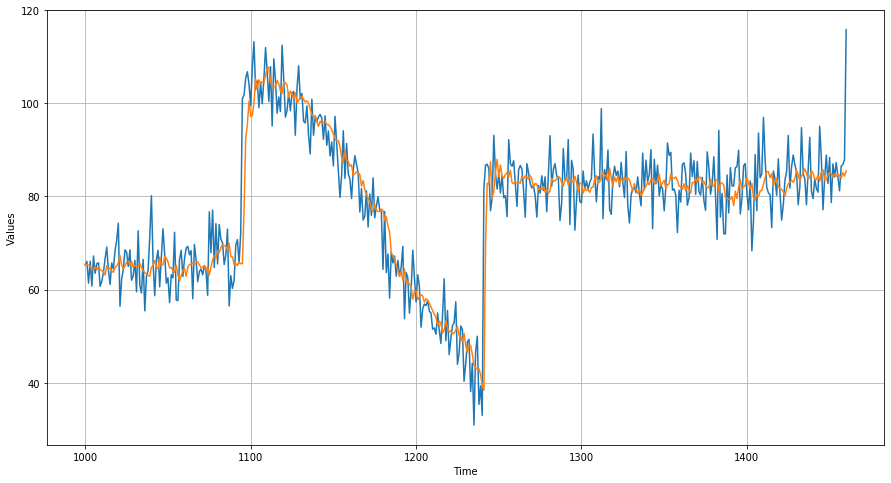

In [40]:
plt.figure(figsize=(15,8))
plot_series(time_valid,x_valid)
plot_series(time_valid,cnn_forecast)
plt.show()

In [41]:
keras.metrics.mean_absolute_error(x_valid,cnn_forecast).numpy()

4.4895005